<a href="https://colab.research.google.com/github/eduardofae/RL/blob/main/AT-03/03%20-%20Value%20Iteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Iteração de Valor

Este Colab foi preparado para que você implemente o algoritmo de Iteração de Valor em um ambiente Gridworld 4x3.

Você irá:

1. **Estender o ambiente Gridworld 4x3**: para permitir que as transições do ambiente sejam consultadas por um agente.
2. **Implementar o algoritmo de Iteração de Valor**: Preencher as partes faltando na classe `ValueIterationAgent` para calcular os valores ótimos dos estados.
3. **Visualizar os resultados**: Utilizar as ferramentas de visualização fornecidas para inspecionar os valores dos estados e a política ótima resultante.

Ao final, você terá uma implementação funcional do algoritmo de Iteração de Valor e uma compreensão de como ele pode ser aplicado para encontrar a política ótima em um ambiente com dinâmica conhecida.

## Tarefa 1 - Grid 4x3 preparado para Programação Dinâmica

O código abaixo deve ser preenchido com a implementação do grid 4x3, com as mesmas especificações do Colab de [MDPs](https://colab.research.google.com/drive/1iNG9EX1-piXQvmN4-wQzncBv4EX7-yZV?usp=sharing). Portanto, você pode/deve aproveitar o código já feito. Note, porém, que há  funções adicionais que você deve preencher, para permitir que o ambiente seja "consultado" para execução de métodos de programação dinâmica.

- get_states(): retorna um `iterable` (e.g. lista, conjunto...) com os estados válidos do ambiente. Lembre-se que "oficialmente" os estados são simplesmente os números de 0 a 11 (por causa do spaces.Discrete). **Importante**: neste caso, o estado 5 'parede' não deve ser considerado válido.
- is_terminal(state): recebe um estado e retorna se ele é terminal ou não.
- get_actions(state): recebe um estado e retorna um `iterable` de ações válidas. As ações correspondentes às 4 direções são válidas, exceto nos estados terminais, onde não há ação válida (retornar `iterable` vazio).
- get_transitions(state,action): recebe um estado e uma ação, e retorna um `iterable` com todos os resultados possíveis de se executar aquela ação naquele estado. Para estados terminais, retornar um `iterable` vazio. Cada resultado possível é uma tupla (p,r,s'), onde p (float) é a probabilidade daquele resultado, r (float) é a recompensa obtida com aquela probabilidade e s' (int) é o estado atingido com aquela probabilidade . Por exemplo, supondo os valores padrão para reward_step (-0.04) e slip (0.2),  se a função for chamada com o estado 10 e ação 0 (ir pra cima) como entrada, o retorno deve ser (a ordem dos elementos na lista não é importante):
```python
[
 (0.1, -0.04, 9), #derrapou  pra esquerda
 (0.8, -0.04, 10), #foi pra cima, se chocou com a parede e permaneceu em 10
 (0.1, 1, 11),  #derrapou pra direita
]
```



### Especificação do GridWorld (igual à tarefa de MDPs)

A célula abaixo tem a especificação do grid 4x3, igual no colab de MDPs. Pode pular se você já tiver feito.



Implemente o ambiente do grid 4x3, preenchendo as células abaixo. Você deve permitir ao usuário especificar a recompensa de cada passo (padrão = -0.04), a probabilidade de 'escorregar' (padrão = 0.2) e o numero máximo de passos antes de encerrar o episódio. O espaço de ações deve ser discreto, com 4 ações (0=UP, 1=RIGHT, 2=DOWN, 3=LEFT), e o de estados também será discreto, com 12 estados (mesmo o estado 'parede' pode ser considerado nesta contagem). A convenção para numeração dos estados é (G=goal, #=parede, P=pit/buraco,S=start):
```
y=2    +----+----+----+----+
       |  8 |  9 | 10 | 11G|
       +----+----+----+----+
y=1    |  4 |  5#|  6 |  7P|
       +----+----+----+----+
y=0    |  0S|  1 |  2 |  3 |
       +----+----+----+----+
        x=0   x=1   x=2   x=3
```

Note que há métodos para converter a numeração de estados para as coordenadas x,y

## Código do GridWorld 4x3

In [ ]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from typing import Optional,Iterable,Tuple
import matplotlib.pyplot as plt


class GridWorld4x3(gym.Env):
    metadata = {"render_modes": ["ansi"]}

    UP = 0
    RIGHT = 1
    DOWN = 2
    LEFT = 4

    def __init__(
        self,
        reward_step: float = -0.04,
        slip: float = 0.2,
        seed: Optional[int] = None,
        render_mode: Optional[str] = None,
    ):
        super().__init__()
        self.reward_step = reward_step
        self.slip = slip
        self.seed = seed

        # Grid Description
        self.grid_size = (4,3)
        self.wall  = [5]
        self.goal  = [11]
        self.pit   = [7]
        self.start = 0

        # COISAS PARA O VIZ
        self.wall_pos = (1,1)
        self.goal_pos = (3,2)
        self.pit_pos = (3,1)
        self.start_pos = (0,0)
        self.nrows = self.grid_size[1]
        self.ncols = self.grid_size[0]

        # Rewards
        self.goal_reward = 1
        self.pit_reward = -1

        # Agent Position
        self.agent_state = self.start

        # Definition of action space
        self.n_actions = 4
        self.action_space = spaces.Discrete(self.n_actions)

        # Definition of observation space
        self.observation_space = spaces.Discrete(self.grid_size[0]*self.grid_size[1])

        # Update Render Mode
        if render_mode:
            self.metadata = {"render_modes": [render_mode]}

    # ---------- conversão estado/posição ----------
    def pos_to_state(self, pos):
        x, y = pos
        return y * self.grid_size[0] + x

    def state_to_pos(self, s):
        return (s % self.grid_size[0], s // self.grid_size[0])

    # ---------- funções pra planning ----------
    def get_states(self) -> Iterable[int]:
        """Retorna todos os estados válidos (exceto parede)."""
        all_states = range(self.grid_size[0]*self.grid_size[1])
        return [state for state in all_states if state not in self.wall]

    def is_terminal(self, state: int) -> bool:
        """Verifica se o estado é terminal (goal ou pit)."""
        return state in self.goal or state in self.pit

    def get_actions(self, state: int) -> Iterable[int]:
        """Retorna ações válidas. Se terminal, nenhuma ação é possível."""
        if self.is_terminal(state): return list()
        return range(self.n_actions)

    def get_transitions(self, state: int, action: int) -> Iterable[Tuple[float, float, int]]:
        """Retorna lista de (p, r, s') para aplicar a ação em um estado."""
        if self.is_terminal(state): return []
        no_slip = self.get_next_state(state, action)
        slip1, slip2 = self.get_possible_slips(action)
        slip1 = self.get_next_state(state, slip1)
        slip2 = self.get_next_state(state, slip2)
        return [
            (1-self.slip, self.get_reward(no_slip), no_slip),
            (self.slip/2, self.get_reward(slip1)  , slip1),
            (self.slip/2, self.get_reward(slip2)  , slip2)
        ]

    # ---------- API Gym ----------
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)

        # Reset agent position and step count
        self.agent_state = self.start

        # Returns
        obs = self.agent_state
        info = {}
        return obs, info

    def is_vertical(self, action: int):
        return action == self.UP or action == self.DOWN

    def handle_slip(self, action: int):
        direction = 1 if np.random.rand() < 0.5 else -1
        action = action + direction
        return action%4 if action != -1 else 3

    def get_possible_slips(self, action: int):
        slip1 = action + 1
        slip1 = slip1%4 if slip1 != -1 else 3
        slip2 = action - 1
        slip2 = slip2%4 if slip2 != -1 else 3
        return slip1, slip2

    def get_next_state(self, state: int, action: int):
        x, y = self.state_to_pos(state)

        if self.is_vertical(action):
            new_y = np.clip(y+(1-action), 0, self.grid_size[1]-1)
            if self.pos_to_state((x,new_y)) not in self.wall:
                y = new_y
        else:
            new_x = np.clip(x+(2-action), 0, self.grid_size[0]-1)
            if self.pos_to_state((new_x,y)) not in self.wall:
                x = new_x

        return self.pos_to_state((x, y))

    def get_reward(self, state: int):
        if state in self.goal:
            return self.goal_reward
        if state in self.pit:
            return self.pit_reward
        return self.reward_step

    def step(self, action: int):
        # Handle slip
        if np.random.rand() < 0.2:
            action = self.handle_slip(action)

        # Update position
        self.agent_state = self.get_next_state(self.agent_state, action)

        # Checks if goal state reached
        terminated = self.agent_state in self.goal

        # Calculates the reward
        reward = self.get_reward(self.agent_state)

        # Not using
        info = {}

        # Returns the agent state
        obs = self.agent_state

        # Ends the episode when max steps reached
        truncated = False
        return obs, reward, terminated, truncated, info

    def render(self, mode=None):
        div = ' ' * 7 + '+----' * self.grid_size[0] + '+'
        for i in range(self.grid_size[1]):
            y = self.grid_size[1]-i-1
            print(div)
            print(f'y={y:<5}', end='')
            for x in range(self.grid_size[0]):
                state = self.pos_to_state((x,y))
                state_class = 'G' if state in self.goal else '#' if state in self.wall else 'P' if state in self.pit else 'S' if state == self.start else ''
                state_print = (str(state) if self.agent_state != state else 'X') + state_class
                print(f'|{state_print:^4}', end='')
            print('|')
        print(div)
        print('        ', end='')
        for x in range(self.grid_size[0]):
            print(f'x={x:<2} ', end='')

    def close(self):
      pass # nao precisa implementar



## Codigo pra testar o Env

A célula abaixo faz o teste básico pra verificar que o ambiente respeita a interface gymnasium

In [ ]:
# Deve continuar passando nos testes do Gymnasium
from gymnasium.utils.env_checker import check_env

# Criar uma instância do ambiente
env = GridWorld4x3()

# This will catch many common issues
try:
    check_env(env)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

Environment passes all checks!


/usr/local/lib/python3.12/dist-packages/gymnasium/utils/env_checker.py:434: UserWarning: WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantiating the environment through `gymnasium.make`
  logger.warn(


## Teste básico de funcionalidade

A célula a seguir testa funcionalidades básicas do grid 4x3: se a lista de estados válidos está correta, alguns casos do teste de terminal, alguns casos do get_action e do get_transitions.

As chamadas com assertEqual recebem e comparam o resultado esperado e o que sua implementação retornar. Se houver divergências, um erro será exibido. Se tudo estiver ok, nenhuma mensagem será exibida.

Você pode adicionar casos de teste se isso ajudar a debugar.

In [ ]:
import unittest
test = unittest.TestCase()

env = GridWorld4x3()
# test whether getstate is working

test.assertEqual(set(env.get_states()),set(range(12)) - {5})

# test some cases of isTerminal
test.assertTrue(env.is_terminal(7))
test.assertTrue(env.is_terminal(11))
test.assertFalse(env.is_terminal(1))
test.assertFalse(env.is_terminal(0))

# test some cases of getAction
test.assertEqual(set(env.get_actions(11)), set())
test.assertEqual(set(env.get_actions(7)), set())
test.assertEqual(set(env.get_actions(0)), set(range(4)))

# test some cases of getTransitions
test.assertEqual(
    set(env.get_transitions(10,0)),
    set([
      (0.1, -0.04, 9), #derrapou  pra esquerda
      (0.8, -0.04, 10), #foi pra cima, se chocou com a parede e permaneceu em 10
      (0.1, 1, 11),  #derrapou pra direita
    ])
)
test.assertEqual(set(env.get_transitions(7,0)), set())

## Tarefa 2 - Agente de Iteração de Valor

Agora você irá implementar o algoritmo de Iteração de Valor. Você irá trabalhar na classe `ValueIterationAgent` fornecida abaixo. Seu objetivo é preencher as partes faltando para que o agente seja capaz de calcular os valores ótimos dos estados e a política ótima resultante para o ambiente recebido. No caso deste enunciado será o grid 4x3.



### Algoritmo, conforme Sutton e Barto 2018

O algoritmo de iteração de valor, conforme o livro segue abaixo.

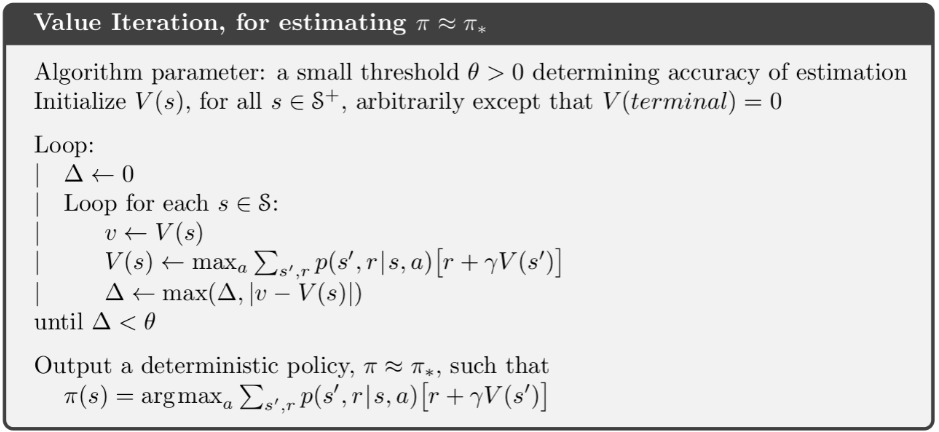

### Sua implementação

Sua implementação terá algumas diferenças com o do livro:

- Ao invés de Δ e do limiar de tolerância, você irá usar um número fixo de iterações
- Na implementação do livro, a atualização dos valores V é "in-place". Porém, sua implementação deverá fazer uma cópia de V a cada iteração do loop principal (externo). Assim, na atribuição V(s) ← max... , você usa o "novo" V pra receber os valores atualizados (lado esquerdo da atribuição) e usa o "velho" V para consultar os valores (lado direito da atribuição).
- Sua implementação não precisa retornar uma política explicitamente, mas haverá um método a ser implementado para consultar a política a partir dos valores que você calcular.


Siga os passos abaixo:

1.  **Entenda o algoritmo**: Revise como a Iteração de Valor funciona, especialmente a equação de Bellman para a otimalidade e como os valores dos estados são atualizados iterativamente.
1.  **Complete o método `Q`**:
    *   Implemente o cálculo do Q-valor para um dado estado e ação.
    *   Utilize o método `get_transitions` do ambiente para obter as possíveis transições (probabilidade, recompensa, próximo estado).
    *   Aplique a fórmula do Q-valor: `Q(s, a) = Σ p(s', r | s, a) * (r + γ * V(s'))`.
1.  **Complete o método `compute_values`**:
    *   Implemente o loop principal que executa um número fixo de iterações.
    *   Dentro do loop, para cada estado não terminal:
        *   Calcule o Q-valor para cada ação possível usando o método `Q` (etapa anterior).
        *   Atualize o valor do estado com o valor máximo de Q encontrado para esse estado.
    *   Para estados terminais, o valor deve ser 0.0.

1.  **Complete o método `greedy_action`**:
    *   Para um dado estado não terminal, determine a ação que maximiza o Q-valor usando a função `Q` que você implementou.
    *   Para estados terminais, retorne `None` (normalmente a função não será chamada para estes estados, mas assim você garante que algo será retornado).

Lembre-se de que você pode usar os métodos `V(s)` (que simplesmente retorna o valor armazenado do estado), `env.get_states()`, `env.is_terminal(state)`, `env.get_actions(state)` e `env.get_transitions(state, action)` fornecidos pela classe do ambiente GridWorld 4x3.

Depois de implementar a lógica, execute a célula de código com a classe `ValueIterationAgent` e, em seguida, a célula de exemplo de uso que utiliza o `AgentVisualizer` para verificar se os valores e a política calculados estão corretos.

In [ ]:
import numpy as np
import gymnasium as gym


class ValueIterationAgent:
    def __init__(self, env: gym.Env, gamma: float) -> None:
        self.env = env
        self.gamma = gamma
        self.V_values = {s: 0.0 for s in self.env.get_states()}

    def V(self, state: int) -> float:
        """Retorna o valor estimado do estado."""
        return self.V_values[state]

    def compute_values(self, iterations: int = 100) -> None:
        """Executa iteração de valor por um número fixo de passos."""
        for i in range(iterations):
            for state in self.env.get_states():
                if self.env.is_terminal(state): continue
                qs = float('-inf')
                for action in self.env.get_actions(state):
                    qs = max(self.Q(state, action), qs)
                self.V_values[state] = qs

    def Q(self, state: int, action: int) -> float:
        """Retorna o valor Q(s,a) com base nas transições do ambiente."""
        #(p, r, s')
        transitions = self.env.get_transitions(state, action)
        summ = 0
        for t in transitions:
            summ += t[0] * (t[1] + self.gamma * self.V(t[2]))
        return summ

    def greedy_action(self, state: int) -> int:
        """Retorna a ação gulosa em relação aos valores atuais."""
        if self.env.is_terminal(state): return None
        best_qsa = float('-inf')
        for action in self.env.get_actions(state):
            qsa = self.Q(state, action)
            if qsa > best_qsa:
                best_qsa = qsa
                best_action = action
        return best_action

## Utilitário para visualizar o agente

In [ ]:
class AgentVisualizer:
    def __init__(self, agent, env):
        """
        agent: ValueIterationAgent-like (tem V(s), Q(s,a) e greedy_action(s))
        env: GridWorld4x3-like (tem nrows, ncols, pos_to_state, state_to_pos, is_terminal, get_states, start_pos, goal_pos, pit_pos, wall_pos)
        """
        self.agent = agent
        self.env = env
        self.action_to_str = {0: "↑", 1: "→", 2: "↓", 3: "←"}

        # Precompute special states
        self.wall_s = self.env.pos_to_state(self.env.wall_pos)
        self.start_s = self.env.pos_to_state(self.env.start_pos)
        self.goal_s = self.env.pos_to_state(self.env.goal_pos)
        self.pit_s = self.env.pos_to_state(self.env.pit_pos)

    # -----------------------
    # Política (setas)
    # -----------------------
    def print_policy(self):
        rows, cols = self.env.nrows, self.env.ncols
        horiz = "+" + "+".join(["------"] * cols) + "+"

        for y in reversed(range(rows)):
            print(horiz)
            cells = []
            for x in range(cols):
                s = self.env.pos_to_state((x, y))
                if s == self.wall_s:
                    content = "##"
                elif s == self.goal_s:
                    content = " G "
                elif s == self.pit_s:
                    content = " P "
                else:
                    a = self.agent.greedy_action(s)
                    arrow = self.action_to_str.get(a, "?")
                    if s == self.start_s:
                        content = f"S{arrow}"
                    else:
                        content = arrow
                cells.append(f"{content:^6}")
            print("|" + "|".join(cells) + "|")
        print(horiz)

    # -----------------------
    # Valores V(s)
    # -----------------------
    def print_values(self):
        rows, cols = self.env.nrows, self.env.ncols
        horiz = "+" + "+".join(["--------"] * cols) + "+"

        for y in reversed(range(rows)):
            print(horiz)
            cells = []
            for x in range(cols):
                s = self.env.pos_to_state((x, y))
                if s == self.wall_s:
                    content = "####"
                else:
                    v = self.agent.V(s)
                    if s == self.goal_s:
                        content = f"G({v:.2f})"
                    elif s == self.pit_s:
                        content = f"P({v:.2f})"
                    else:
                        content = f"{v:6.2f}"
                cells.append(f"{content:^8}")
            print("|" + "|".join(cells) + "|")
        print(horiz)

    # -----------------------
    # Q-values
    # -----------------------
    def print_qvalues(self):
        rows, cols = self.env.nrows, self.env.ncols
        horiz = "+" + "+".join(["-------------"] * cols) + "+"

        for y in reversed(range(rows)):
            print(horiz)
            # três linhas por célula
            line1, line2, line3 = [], [], []
            for x in range(cols):
                s = self.env.pos_to_state((x, y))
                if s == self.wall_s:
                    c1 = "#############"
                    c2 = "#############"
                    c3 = "#############"
                elif self.env.is_terminal(s):
                    v = self.agent.V(s)
                    if s == self.goal_s:
                        txt = f"G({v:.2f})"
                    elif s == self.pit_s:
                        txt = f"P({v:.2f})"
                    else:
                        txt = f"T({v:.2f})"
                    c1 = f"{txt:^13}"
                    c2 = " " * 13
                    c3 = " " * 13
                else:
                    qvals = [self.agent.Q(s, a) for a in range(4)]
                    best = int(np.argmax(qvals))
                    up = f"↑:{qvals[0]:.2f}"
                    left = f"←:{qvals[3]:.2f}"
                    right = f"→:{qvals[1]:.2f}"
                    down = f"↓:{qvals[2]:.2f}"
                    c1 = f"{up:^13}"
                    c2 = f"{left:<6}{right:>7}"
                    c3 = f"{down:^13}"
                line1.append(c1)
                line2.append(c2)
                line3.append(c3)

            # agora cada linha recebe delimitadores
            print("|" + "|".join(line1) + "|")
            print("|" + "|".join(line2) + "|")
            print("|" + "|".join(line3) + "|")
        print(horiz)


## Execução da visualização do agente

Ao executar o código abaixo, a saída esperada para 50 iterações e gamma=0.9 é como abaixo.

IMPORTANTE: se a sua execução resultar em números ligeiramente diferentes, não é necessariamente um erro, mas as seguintes condições devem ser satisfeitas:

1. A política e os Q-valores devem estar consistentes (a ação de maior valor deve ser a indicada na política).
1. V e Q devem ser consistentes o valor do estado deve corresponder ao da melhor ação (estamos considerando a política gulosa -- premissa da iteração de valor).

```
=== Política ===
+------+------+------+------+
|  →   |  →   |  →   |  G   |
+------+------+------+------+
|  ↑   |  ##  |  ↑   |  P   |
+------+------+------+------+
|  S↑  |  →   |  ↑   |  ←   |
+------+------+------+------+

=== V(s) ===
+--------+--------+--------+--------+
|   0.61 |   0.77 |   0.93 |G(0.00) |
+--------+--------+--------+--------+
|   0.49 |  ####  |   0.58 |P(0.00) |
+--------+--------+--------+--------+
|   0.37 |   0.33 |   0.43 |   0.19 |
+--------+--------+--------+--------+

=== Q(s,a) ===
+-------------+-------------+-------------+-------------+
|   ↑:0.52    |   ↑:0.65    |   ↑:0.80    |   G(0.00)   |
|←:0.50 →:0.61|←:0.54 →:0.77|←:0.65 →:0.93|             |
|   ↓:0.43    |   ↓:0.65    |   ↓:0.55    |             |
+-------------+-------------+-------------+-------------+
|   ↑:0.49    |#############|   ↑:0.58    |   P(0.00)   |
|←:0.40 →:0.40|#############|←:0.50→:-0.69|             |
|   ↓:0.32    |#############|   ↓:0.22    |             |
+-------------+-------------+-------------+-------------+
|   ↑:0.37    |   ↑:0.27    |   ↑:0.43    |   ↑:-0.75   |
|←:0.31 →:0.27|←:0.29 →:0.33|←:0.29 →:0.19|←:0.19 →:0.02|
|   ↓:0.29    |   ↓:0.27    |   ↓:0.31    |   ↓:0.15    |
+-------------+-------------+-------------+-------------+
```

In [ ]:
env = GridWorld4x3()
agent = ValueIterationAgent(env, gamma=0.9)
agent.compute_values(iterations=50)

viz = AgentVisualizer(agent, env)

print("=== Política ===")
viz.print_policy()

print("\n=== V(s) ===")
viz.print_values()

print("\n=== Q(s,a) ===")
viz.print_qvalues()



=== Política ===
+------+------+------+------+
|  →   |  →   |  →   |  G   |
+------+------+------+------+
|  ↑   |  ##  |  ↑   |  P   |
+------+------+------+------+
|  S↑  |  →   |  ↑   |  ←   |
+------+------+------+------+

=== V(s) ===
+--------+--------+--------+--------+
|   0.61 |   0.77 |   0.93 |G(0.00) |
+--------+--------+--------+--------+
|   0.49 |  ####  |   0.58 |P(0.00) |
+--------+--------+--------+--------+
|   0.37 |   0.33 |   0.43 |   0.19 |
+--------+--------+--------+--------+

=== Q(s,a) ===
+-------------+-------------+-------------+-------------+
|   ↑:0.52    |   ↑:0.65    |   ↑:0.80    |   G(0.00)   |
|←:0.50 →:0.61|←:0.54 →:0.77|←:0.65 →:0.93|             |
|   ↓:0.43    |   ↓:0.65    |   ↓:0.55    |             |
+-------------+-------------+-------------+-------------+
|   ↑:0.49    |#############|   ↑:0.58    |   P(0.00)   |
|←:0.40 →:0.40|#############|←:0.50→:-0.69|             |
|   ↓:0.32    |#############|   ↓:0.22    |             |
+------------

## Bônus: explore sua implementação

Teste diversos gamma para verificar seu efeito nos valores e na política. Teste também, diferentes configurações do ambiente (slip e step_reward) para verificar como o comportamento ótimo do agente pode mudar para determinados tipos de configuração.